# Floating-point arithmetic

Arbitrary real numbers on computers are typically approximated by a set $\mathbb{F}$ of [floating-point numbers](https://en.wikipedia.org/wiki/Floating_point).  Basically, you should think of these as numbers in "scientific notation:"
$$
\pm\underbrace{d_0.d_1 d_2 d_3 ... d_{p-1}}_\textrm{significand} \times \beta^e, \;\; 0 \le d_k < \beta
$$
where the $d_k$ are digits of the **significand** in some base $\beta$ (typically $\beta=2$), the number of digits $p$ is the **precision**, and $e$ is the **exponent**.  That is, the computer actually stores a tuple (*sign*,*significand*,*exponent*), representing *a fixed number of significant digits over a wide range of magnitudes*.

Our goal is to eventually understand the set $\mathbb{F}$, how *rounding* occurs when you operate on floating-point values, how rounding errors *accumulate*, and how you analyze the accuracy of numerical algorithms.  In this notebook, however, we will just perform a few informal experiments in [Julia](http://julialang.org/) to get a feel for things.

## Entering and working with floating-point values

In [1]:
1.5e7 # a floating-point value 1.5 × 10⁷

1.5e7

In [2]:
x = 1/49 # division of two integers produces a floating-point value

0.02040816326530612

Since $1/49 \notin \mathbb{F}$, however, $x$ is actually a *rounded* version of $1/49$, and multiplying it by $49$ will yield something that is close to but *not quite equal to 1*.

In [3]:
x * 49

0.9999999999999999

In [4]:
1 - x * 49

1.1102230246251565e-16

This is about $10^{-16}$ because the default floating-point precision in Julia is **double precision**, with $p=53$ bits of significand ($\beta=2$).   Double precision, called the `Float64` type in Julia (64 bits overall), is used because it is **fast**: double-precision floating-point arithmetic is implemented by dedicated circuits in your CPU.

The precision can also be described by $\epsilon = 2^{p-1}$, which bounds the *relative error* between any element of $\mathbb{R}$ and the closest element of $\mathbb{F}$.  It is returned by `eps()` in Julia:

In [5]:
2.0^-52, eps(), eps(1.0), eps(Float64) # these are all the same thing

(2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16)

* An error by 1 in the **last significant digit** is called a **1 [ulp](https://en.wikipedia.org/wiki/Unit_in_the_last_place)** (**u**nit in the **l**ast **p**lace) error, equivalent to a relative error of $\epsilon$.

In fact, there is typically a small rounding error as soon as you enter a floating-point value, because most decimal fractions are not in $\mathbb{F}$.   This can be seen by either:
* converting to a higher precision with `big(x)` (converts to `BigFloat` [arbitrary-precision](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic) value, by default with $p=256 bits$ or about 80 decimal digits)
* comparing to an exact rational — in Julia, `p // q` produces a `Rational` type, which is stored as a pair of integers

In [6]:
# 1.5 is exactly represented in binary floating point:
big(1.5), 1.5 == 3//2

(1.5, true)

In [7]:
# 0.1 is *not* exactly represented
big(0.1), 0.1 == 1//10

(0.1000000000000000055511151231257827021181583404541015625, false)

## Accumulation of roundoff errors

A common mistake is to confuse **precision** with **accuracy**.   A value can be *more accurate* or *less accurate* than the precision (number of digits) with which it is represented.

For example, the value `3.0` in floating point (represented exactly in $\mathbb{F}$) is an exact value for the number of sides of a triangle, but a rather inaccurate approximation for π.

Most commonly, floating-point values are *less accurate* than the precision allows, because **roundoff errors accumulate** over the course of a long computation.   To see this, let us consider the function `y = cumsum(x)` in Julia, which computes
$$
y_k = \sum_{i=1}^k x_i
$$
We will try this for random $x_i \in [0,1)$, and compare to the "exact" value of the sum.  Although `cumsum` is built-in to Julia, we will write our own version so that we can see exactly what it is doing:

In [8]:
function my_cumsum(x)
    y = similar(x) # allocate an array of the same type and size as x
    y[1] = x[1]
    for i = 2:length(x)
        y[i] = y[i-1] + x[i]
    end
    return y
end

my_cumsum (generic function with 1 method)

Now, how to we get the "exact" sum for comparing the error?   One possible trick is that we can do the sum in **two precisions**: *double precision* and *single precision* (Julia `Float32` = 32 bits), where single precision is about 7-8 decimal digits ($p=24$ bits).  Since double precision has about twice as many digits as single precision, we can treat the double precision result as "exact" compared to the single-precision result in order to compute the accuracy in the latter.

* Alternatively, there is a package called [Xsum.jl](https://github.com/stevengj/Xsum.jl) for Julia that computes exactly rounded sums in double precision using an [algorithm by Radford Neal](https://arxiv.org/abs/1505.05571) that uses a little bit of extra precision as needed.

In [9]:
eps(Float32), eps(Float64)

(1.1920929f-7, 2.220446049250313e-16)

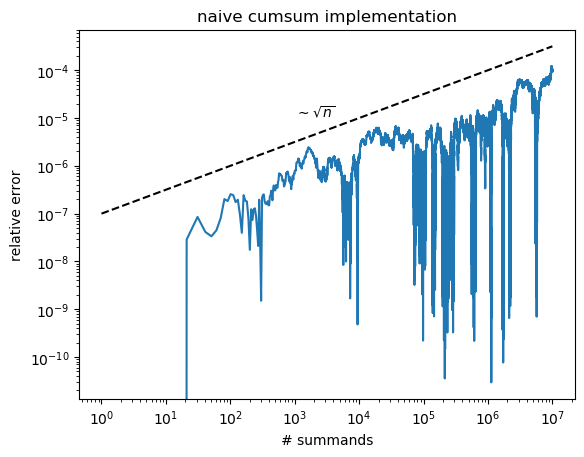

  0.045860 seconds (19.86 k allocations: 39.196 MiB)


PyObject Text(0.5, 1, 'naive cumsum implementation')

In [10]:
x = rand(Float32, 10^7) # 10^7 single-precision values uniform in [0,1)
@time y = my_cumsum(x)
yexact = my_cumsum(Float64.(x)) # same thing in double precision
err = abs.(y .- yexact) ./ abs.(yexact) # relative error in y

using PyPlot
n = 1:10:length(err) # downsample by 10 for plotting speed
loglog(n, err[n])
ylabel("relative error")
xlabel("# summands")
# plot a √n line for comparison
loglog([1,length(err)], sqrt.([1,length(err)]) * 1e-7, "k--")
text(1e3,1e-5, L"\sim \sqrt{n}")
title("naive cumsum implementation")

Note that the error starts around $10^{-7}$ (about `eps(Float32)`), but gets worse than the precision as the number of summands grows.

As you can see, the relative error has an upper bound that scales roughly proportional $\sqrt{n}$ where $n$ is the number of summands.   Intuitively, there is a little roundoff error from each addition, but the roundoff error is somewhat random in $[-\epsilon,+\epsilon]$ and hence the roundoff errors grow as a [random-walk](https://en.wikipedia.org/wiki/Random_walk) process $\sim \sqrt{n}$.

However, **one can do better than this**.  If you use the built-in `cumsum` function, you will see *very different* error growth: the mean errors actually grow as roughly $\sqrt{\log n}$.  Not only that, but the output of the `@time` macro indicates that the built-in `cumsum` (which is also written in Julia) is actually a bit *faster* than our `my_cumsum`.

We will have to investigate summation in more detail to understand how this can be possible.

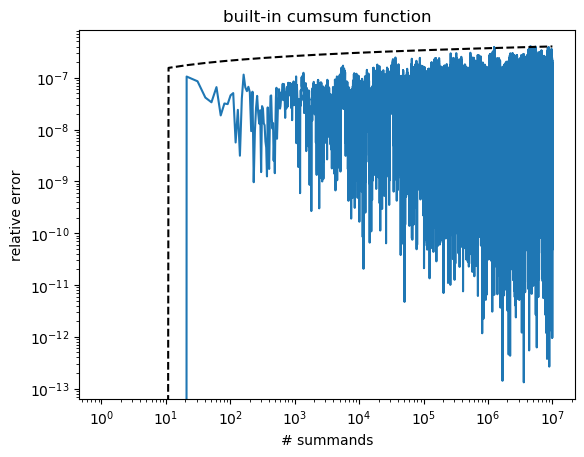

  0.063271 seconds (200.47 k allocations: 48.055 MiB)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13da6b240>

In [11]:
@time y2 = cumsum(x)
err2 = abs.(y2 .- yexact) ./ abs.(yexact)
loglog(n, err2[n])
ylabel("relative error")
xlabel("# summands")
title("built-in cumsum function")
loglog(n, sqrt.(log.(n)) * 1e-7, "k--")

## Rounding mode

By default, each elementary floating-point operation (`+`, `-`, `*`, `/`) behaves as if it computed its result in infinite precision and then rounded the result to the *nearest* floating-point value (rounding to the nearest *even* value in the case of ties).  This is called **correct rounding** or **exact rounding**.

The `rounding` function in Julia returns the current rounding behavior for a given type, and defaults to rounding to the nearest value:

In [12]:
rounding(Float32)

RoundingMode{:Nearest}()

However, it is possible to *change* the rounding mode to always round *up* (or *down*) with the `setrounding` function from the [SetRounding.jl package](https://github.com/JuliaIntervals/SetRounding.jl).  (In C/C++ you would use the [`fesetround`](https://en.cppreference.com/w/c/numeric/fenv/feround) function.)

First, let's install this package if needed.  We can do `import Pkg` followed by `Pkg.add("SetRounding")`, but it is nicer to simply start an input cell with `]` at which point you are in "package mode" and have a set of [nice package-management commands](https://docs.julialang.org/en/v1/stdlib/Pkg/) available:

In [13]:
] add SetRounding

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %=========>                               ]  21.8 %]  43.3 %===========================>             ]  65.1 %===========================>             ]  67.3 %88.8 % Resolving package versions...
 Installed ZeroMQ_jll ─ v4.3.1+0
 Installed ZMQ ──────── v1.2.0
 Installed MacroTools ─ v0.5.4
  Updating `~/.julia/environments/v1.3/Project.toml`
  [3cc68bcd] + SetRounding v0.2.0
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [3da002f7] ↑ ColorTypes v0.9.0 ⇒ v0.9.1
  [5ae59095] ↑ Colors v0.11.0 ⇒ v0.11.2
  [864edb3b] ↑ DataStructures v0.17.6 ⇒ v0.17.9
  [53c48c17] ↑ FixedPointNumbers v0.7.0 ⇒ v0.7.1
  [1914dd2f] ↑ MacroTools v0.5.3 ⇒ v0.5.4
  [69de0a69] ↑ Parsers v0.3.10 ⇒ v0.3.11
  [3cc68bcd] + SetRounding v0.2.0
  [c2297ded] ↑ ZMQ v1.0.0 ⇒ v1.2.0
  [8f1865be] + ZeroMQ_jll v4.3.1+0


In [14]:
using SetRounding

┌ Info: Precompiling SetRounding [3cc68bcd-71a2-5612-b932-767ffbe40ab0]
└ @ Base loading.jl:1273


Changing the rounding mode is supported in the CPU hardware, so it doesn't change the speed of floating-point arithmetic.   It can be extremely useful to gain an understanding of the roundoff errors in a problem, and can even be used to implement [interval arithmetic](https://en.wikipedia.org/wiki/Interval_arithmetic), in which you compute a range `[a,b]` that bounds your error rather than a single rounded value — see [IntervalArithmetic.jl](https://github.com/JuliaIntervals/IntervalArithmetic.jl) in Julia. 

In the case of our summation problem, we can change to rounding up, which will result in a very different error growth: O(n) rather than O(√n).  The errors now all accumulate in the same direction, so they no longer form a random walk

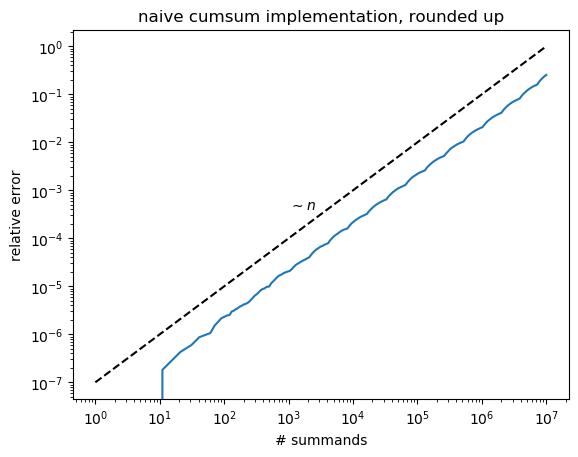

PyObject Text(0.5, 1, 'naive cumsum implementation, rounded up')

In [15]:
errup = setrounding(Float32, RoundUp) do
    # error in single-precision (Float32) sum, rounding temporarily set to RoundUp
    abs.(my_cumsum(x) .- yexact) ./ abs.(yexact) # relative error in y
end

loglog(n, errup[n])
ylabel("relative error")
xlabel("# summands")
# plot an O(n) line for comparison
loglog([1,length(errup)], [1,length(errup)] * 1e-7, "k--")
text(1e3,4e-4, L"\sim n")
title("naive cumsum implementation, rounded up")

## Overflow, Underflow, Inf, and NaN

Because a floating-point value uses a finite number of bits to store the exponent `e`, there is a maximum and minimum magnitude for floating-point values.   If you go over the maximum, you **overflow** to a special `Inf` value (or `-Inf` for large negative values), representing $\infty$.   If you go under the minimum, you **underflow** to $\pm 0.0$, where $-0$ is used to represent e.g. a value that underflowed from the negative side.

In [16]:
1e300 # okay: 10³⁰⁰ is in the representable range

1.0e300

In [17]:
(1e300)^2 # overflows

Inf

We can get the maximum representable magnitude via `floatmax`

In [18]:
floatmax(Float64), floatmax(Float32)

(1.7976931348623157e308, 3.4028235f38)

In [19]:
1e-300 # okay

1.0e-300

In [20]:
(1e-300)^2 # underflows to +0

0.0

You can use `floatmin` in Julia to find the minimum-magnitude floating-point value:

In [21]:
floatmin(Float64), floatmin(Float32)

(2.2250738585072014e-308, 1.1754944f-38)

In [22]:
-1e-300 * 1e-300 # underflows to -0

-0.0

While -0 is printed differently from +0, they still compare equal.  However, you will notice the difference if you do something that depends on the sign:

In [23]:
+0.0 == -0.0

true

In [24]:
1 / +0.0, 1 / -0.0

(Inf, -Inf)

In [25]:
signbit(+0.0), signbit(-0.0)

(false, true)

Since 1/-Inf is -0.0, this has the nice property that:

In [26]:
1 / (1 / -Inf)

-Inf

A special value `NaN` ("not a number") is used to represent the result of floating-point operations that can't be defined in a sensible way (e.g. [indeterminate forms](https://en.wikipedia.org/wiki/Indeterminate_form)):

In [27]:
0 * Inf, Inf / Inf, 0 / 0

(NaN, NaN, NaN)

In some other languages, `NaN` is also used to signal that a function cannot be evaluated.  For example, in C, `sqrt(-1.0)` returns `NaN`.  However, Julia typically [throws](http://docs.julialang.org/en/latest/manual/control-flow/#man-exception-handling) an [exception](https://en.wikipedia.org/wiki/Exception_handling) in these cases:

In [28]:
sqrt(-1.0)

DomainError: DomainError with -1.0:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

If you want a complex *output* from the `sqrt` function, you need to give it a complex *input*:

In [29]:
sqrt(-1.0 + 0im)

0.0 + 1.0im

The reason for this is a technical criterion called [type stability](http://docs.julialang.org/en/latest/manual/performance-tips/#write-type-stable-functions) that is essential for Julia code to be compiled to fast machine instructions.  (The lack of type stability in many standard-library functions is a key contributor to the difficulty of retrofitting fast compilers to languages like Python and Matlab.)

## Cancellation error

One common source of huge floating-point errors is a [catastrophic cancellation](https://en.wikipedia.org/wiki/Loss_of_significance): if you **subtract two nearly equal numbers** then most of the significant digits cancel, and the result can have a relative error $\gg \epsilon$.

Catastrophic cancellation is not inevitable, however!  Often it can be avoided simply by **re-arranging your calculation**.

### The `expm1` function

Suppose you are calculating the function $e^x - 1$ using floating-point arithmetic.   When $|x| \ll 1$, we have $e^x \approx 1$, and so a naive calculation $e^x \ominus 1$ will experience catastrophic cancellation:

In [33]:
x = 2.0^-60
@show x
@show exp(x)
@show exp(x) - 1 # naive algorithm: catastrophic cancellation

x = 8.673617379884035e-19
exp(x) = 1.0
exp(x) - 1 = 0.0


0.0

This result `0.0` has **no correct digits**.  The correct answer is:

In [34]:
# naive algorithm computed in BigFloat precision and rounded back to Float64:
Float64(exp(big(x)) - 1)

8.673617379884035e-19

You can also see this using the Taylor expansion of $e^x$:

$$
e^x - 1 = \left(1 + x + \frac{x^2}{2} + \cdots + \frac{x^n}{n!} + \cdots\right) - 1 = \boxed{x + \frac{x^2}{2} + \cdots + \frac{x^n}{n!} + \cdots}
$$
which we can use to calculate this function accurately for small $x$:

In [35]:
x + x^2/2 + x^3/6 # 3 terms is more than enough for x ≈ 8.7e-19

8.673617379884035e-19

The key is to **rearrange the calculation** to **perform the cancellation analytically**, and only use floating-point arithmetic *after* this is accomplished.

In fact, Julia's standard library (and scientific-computing libraries in other languages) provides a function called `expm1(x)` that computes $e^x - 1$ accurately for all `x`:

In [36]:
expm1(x)

8.673617379884035e-19

Such [special functions](https://en.wikipedia.org/wiki/Special_functions) can be implemented in many ways.  One possible implementation of `expm1` might be:

* Just do `exp(x) - 1` if $|x|$ is sufficiently large.
* Use the Taylor series if $|x|$ is small.
* In between (e.g. $|x| \sim 1$), to avoid requiring many terms of the Taylor series, one could use some kind of fit, e.g. a [minimax polynomial](https://en.wikipedia.org/wiki/Minimax_approximation_algorithm) or [rational function](https://en.wikipedia.org/wiki/Rational_function).

(In general, special-function implementations typically use some combination of Taylor series near zeros, minimax fits, continued-fraction expansions or asymptotic series, and function-specific identities.  This is a branch of numerical analysis that we won't delve into in 18.335.)

Sometimes, a simple (but often non-obvious) algebraic rearrangement leads to a formula that is accurate for all $x$.  For example, in this case one can use the exact identities:
$$
e^x - 1 = \left(e^x+1\right)\tanh(x/2) = \frac{\left(e^x - 1\right) x}{\log\left(e^x\right)}
$$
and it turns out that the catastrophic cancellation is avoided with either of the two expressions at right, at the cost of calling `tanh` or `log` in addition to `exp`.  See e.g. Higham, [*Accuracy and Stability of Numerical Algorithms*](https://epubs.siam.org/doi/book/10.1137/1.9780898718027?mobileUi=0) (2002), p. 30 for more explanation and references.

### Quadratic roots

If you are finding solutions of the quadratic equation
$$
ax^2 + bx + c = 0
$$
you will surely reach for the [quadratic formula](https://en.wikipedia.org/wiki/Quadratic_formula):
$$
x_\pm = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$
However, suppose $b > 0$ and $|ac| \ll b^2$.   In this case, $\sqrt{b^2 - 4ac} \approx b$.  The $x_-$ root will be fine, but the $x_+$ root will suffer from a catastrophic cancellation because $-b + \sqrt{\cdots}$ is the difference of two nearly equal quantities.

To compute $x_+$, we could again use a Taylor series, but it turns out that we can instead use a simple re-arrangement:
$$
x_\pm = \frac{2c}{-b \mp \sqrt{b^2 - 4ac}}
$$
which comes from dividing our quadratic equation by $x^2$ and applying the standard quadratic formula to $cy^2 + by + a = 0$ where $y = 1/x$.   This "inverted" form of the quadratic formula is accurate for $x_+$ (again assuming $b > 0$) but may have catastrophic cancellation for $x_-$.

So, we just use the first quadratic formula for the $x_-$ root and the second "inverted" quadratic formula for the $x_+$ root.  No increase in computational cost, just a little thought and rearrangement.